In [1]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil
import matplotlib.pyplot as plt
import time

from torchmetrics.detection import MeanAveragePrecision
from torchvision.transforms import v2
from torchvision import datasets, tv_tensors
from torchvision.io import read_image
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetaForObjectDetection
from transformers import DetaConfig, DetaImageProcessor
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw
from mean_average_precision import MetricBuilder



In [2]:


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, image_name, transforms=None):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file, transforms)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        
		
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset

    #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

    #Maximal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_max', processor=processor, image_name="coco_train_max.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_max', processor=processor, image_name="coco_val_max.json")

    # Dataset with Augmentations
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_combined', processor=processor, image_name="coco_Combined.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_combined', processor=processor, image_name="coco_Combined.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))



cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

def collate_fn(batch):
	pixel_values = [item[0] for item in batch]
	encoding = processor.pad(pixel_values, return_tensors="pt")
	labels = [item[1] for item in batch]
	batch = {}
	batch['pixel_values'] = encoding['pixel_values']
	batch['pixel_mask'] = encoding['pixel_mask']
	batch['labels'] = labels
	return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of training examples: 1718
Number of validation examples: 430


In [3]:
class Deta(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetaForObjectDetection.from_pretrained("jozhang97/deta-resnet-50",
                                                            num_labels=len(id2label),
                                                            auxiliary_loss=True,
                                                            ignore_mismatched_sizes=True)
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.processor = DetaImageProcessor.from_pretrained("jozhang97/deta-resnet-50")
        self.save_hyperparameters()
        self.val_epoch_count = 0 # to not log at the first run
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        self.val_ap = []
        self.train_ap = []
        self.train_metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=9)
        self.val_metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=9)

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        return outputs

    def common_step(self, batch, batch_idx, t_v):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        

        # turn into a list of dictionaries (one item for each example in the batch)
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0.02)
        
        gt = []
        size = batch["labels"][0]["class_labels"].size()
        for i in range(0, size[0]):
            n = []
            n.extend(batch["labels"][0]["boxes"][i])
            n.extend([batch["labels"][0]["class_labels"][i]])
            n.extend([0]) # difficulty
            n.extend([batch["labels"][0]["iscrowd"][i]])
            gt.append(n)

        preds = []
        sizep = len(results[0]["labels"])
        for i in range(0, sizep):
            m = []
            m.extend(results[0]["boxes"][i])
            m.extend([results[0]["labels"][i]])
            m.extend([results[0]["scores"][i]])
            preds.append(m)

        gt = torch.tensor(gt)
        preds = torch.tensor(preds)
        #if t_v:
        #	self.data_prep_train(pixel_values, pixel_mask, labels)
        #else:
        #	self.data_prep_val(pixel_values, pixel_mask, labels)

        return loss, loss_dict, preds, gt

    def training_step(self, batch, batch_idx):
        loss, loss_dict, preds, gt = self.common_step(batch, batch_idx, True)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.train_metric_fn.add(preds, gt)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def on_train_epoch_end(self) -> None:
        metrics = self.train_metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')
        ap = metrics["mAP"]
        print(ap)
        self.train_ap.append(ap)
        wandb.log({"train_epoch_AP": ap})
        self.train_metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=9)

    """def on_train_epoch_end(self) -> None:
        print("onTrainEpoch")
        t1 = time.time()
        self.cmetric = MeanAveragePrecision(iou_type="bbox")
        self.cmetric.update(self.training_step_pred, self.training_step_targ)
        result = self.cmetric.compute()
        counter = 0
        for k, v in result.items():
            counter += 1
            if counter < 15:
                wandb.log({"train_epoch_" + k: v.item()})
                print({"train_" + k: v.item()})
        self.training_step_pred = []
        self.training_step_targ = []
        t2 = time.time()
        print(round(t2 - t1, 4))"""

    def validation_step(self, batch, batch_idx):
        loss, loss_dict, preds, gt = self.common_step(batch, batch_idx, False)
        self.val_metric_fn.add(preds, gt)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss

    def on_validation_epoch_end(self) -> None:
        vmetrics = self.val_metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')
        ap = vmetrics["mAP"]
        print(ap)
        self.val_ap.append(ap)
        wandb.log({"val_epoch_AP": ap})
        self.val_metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=9)

    """def on_validation_epoch_end(self) -> None:
        if self.val_epoch_count == 1:
            print("onValEpoch")
            t1 = time.time()
            self.cmetric = MeanAveragePrecision(iou_type="bbox")
            self.cmetric.update(self.training_step_pred, self.training_step_targ)
            result = self.cmetric.compute()
            counter = 0
            for k, v in result.items():
                counter += 1
                if counter < 15:
                    wandb.log({"validation_epoch_" + k: v.item()})
                    print({"validation_epoch_" + k: v.item()})
            self.validation_step_pred = []
            self.validation_step_targ = []
            t2 = time.time()
            print(round(t2 - t1, 4))
        else:
            self.val_epoch_count = 1"""

    def configure_optimizers(self):
        param_dicts = [
                {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
                {
                    "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                    "lr": self.lr_backbone,
                },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                    weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    """def data_prep_train(self, pixel_values, pixel_mask, labels):

        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
        for n in results:
            self.training_step_pred.append(n)
        for i in labels:
            self.training_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})

    def data_prep_val(self, pixel_values, pixel_mask, labels):

        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = self.processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)
        for n in results:
            self.validation_step_pred.append(n)
        for i in labels:
            self.validation_step_targ.append({"boxes":i["boxes"], "labels":i["class_labels"]})"""

In [6]:

import pprint
sweep_config = {
    "name": "Sweeps_DETA",
    "method":"random"
}
metric = {
    "name": "validation_loss",
    "goal": "minimize"
}

sweep_config["metric"] = metric

parameters_dict = {
    "learning_rate_backbone" : {
        "distribution": "uniform",
        "min": 0.000001,
        "max": 0.001
    },
    "learning_rate_transformer" : {
        "distribution": "uniform",
        "min": 0.000001,
        "max": 0.001
    },
    "weight_decay" : {
        "distribution": "uniform",
        "min": 0.000001,
        "max": 0.001
    },
}
sweep_config['parameters'] = parameters_dict

pprint.pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project="BAA_Book_Damage_Detection_Sweeps")
sweep_id


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'validation_loss'},
 'name': 'Sweeps_DETA',
 'parameters': {'learning_rate_backbone': {'distribution': 'uniform',
                                           'max': 0.001,
                                           'min': 1e-06},
                'learning_rate_transformer': {'distribution': 'uniform',
                                              'max': 0.001,
                                              'min': 1e-06},
                'weight_decay': {'distribution': 'uniform',
                                 'max': 0.001,
                                 'min': 1e-06}}}
Create sweep with ID: py9pxlza
Sweep URL: https://wandb.ai/damaged-books-detection-ml/BAA_Book_Damage_Detection_Sweeps/sweeps/py9pxlza


'py9pxlza'

config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "DETA",
            "dataset": "All_Data",
            "train_set_size": len(train_dataset)}

In [7]:
# Training


def train(config=None):


    # login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
    wandb.login()

    with wandb.init(config=config):

        config = wandb.config

        #date = datetime.datetime.now()
        #run_name = "Run at the {}".format(date)

        lr = config.learning_rate_transformer #1e-4 original
        lr_backbone=config.learning_rate_backbone #1e-5 original
        weight_decay=config.weight_decay #1e-4 original

        project = "BAA_Book_Damage_Detection_Sweeps"

        model = Deta(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

        model.to(device)

        # outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
        # print(outputs.logits.shape)

        max_steps_var = 6000

        wandb_logger = WandbLogger("DETA", "../models/", project=project, log_model=True, checkpoint_name=f"DETA_Sweep_{max_steps_var}_Steps")
        trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
        trainer.fit(model)

        wandb.finish()

In [8]:
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Agent Starting Run: dc124fjg with config:
wandb: 	learning_rate_backbone: 0.0002084095730798829
wandb: 	learning_rate_transformer: 0.0003197948604989163
wandb: 	weight_decay: 0.0009312541137564
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


0.0


c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

0.0
0.0


Validation: |          | 0/? [00:00<?, ?it/s]

0.0
0.0


Validation: |          | 0/? [00:00<?, ?it/s]

0.0
0.0
0.0


`Trainer.fit` stopped: `max_steps=6000` reached.


wandb: Agent Starting Run: eucwn15q with config:
wandb: 	learning_rate_backbone: 0.0006261814262871722
wandb: 	learning_rate_transformer: 0.0001432147817877794
wandb: 	weight_decay: 0.0007651887812039484
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

0.0
0.0


Validation: |          | 0/? [00:00<?, ?it/s]

0.0
0.0


Validation: |          | 0/? [00:00<?, ?it/s]

0.0
0.0
0.0


`Trainer.fit` stopped: `max_steps=6000` reached.


wandb: Agent Starting Run: 3bul0hhv with config:
wandb: 	learning_rate_backbone: 0.0003624803412274213
wandb: 	learning_rate_transformer: 0.0006076030273140571
wandb: 	weight_decay: 0.000729063852164171
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.de

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0.0


Training: |          | 0/? [00:00<?, ?it/s]

In [3]:
wandb.finish()
wandb.teardown()

# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DETA_300_Steps:v0', type='model')
artifact_dir = artifact.download()

model = Deta.load_from_checkpoint(artifact_dir + "/model.ckpt")

In [5]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/DETA_AP_20000_Steps:v0', type='model')
# artifact = run.use_artifact("../models/ut10b6wq/epoch=108-step=93631.ckpt")
artifact_dir = artifact.download()

model = Deta.load_from_checkpoint(artifact_dir + "/model.ckpt")

wandb: Downloading large artifact DETA_AP_20000_Steps:v0, 551.94MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5
Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-resnet-50 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- model.decoder.class_

In [6]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Deta(
  (model): DetaForObjectDetection(
    (model): DetaModel(
      (backbone): DetaBackboneWithPositionalEncodings(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetaFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetaFrozenBatchNorm2d()
                    )
                    (layer):

In [7]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/430 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.32s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.105
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.5565, 0.5298, 0.4958, 0.4722, 0.4637, 0.4396, 0.4300, 0.4255, 0.4135,
        0.3930, 0.3720, 0.2797, 0.2545, 0.2228, 0.2222, 0.2028, 0.1859],
       device='cuda:0'), 'labels': tensor([3, 4, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 3, 6, 3, 3], device='cuda:0'), 'boxes': tensor([[1239.7074,  432.3155, 1270.6050,  588.2725],
        [1250.7198,  641.7019, 1273.4235,  836.1144],
        [ 356.5234,  851.2101,  369.7219,  867.6694],
        [1194.9182,  485.0581, 1215.3055,  581.5770],
        [1253.2229,  639.9095, 1275.5492,  907.5840],
        [ 754.3665,  461.5968,  794.7233,  491.1888],
        [1252.7167,  647.3503, 1273.4945,  789.6819],
        [ 981.0978,  788.2090,  994.0760,  805.7853],
        [ 455.0473,  558.2562,  472.6524,  577.7448],
        [1162.7781,  862.7283, 1179.8921,  914.2719],
        [1335.0671,  692.2448, 1363.6093,  918.9362],
        [ 524.4174,  301.1392,  591.0886,  584.4193],
        [1246.3357,  645.3599, 1267.0723,  807.5944],
        [ 70

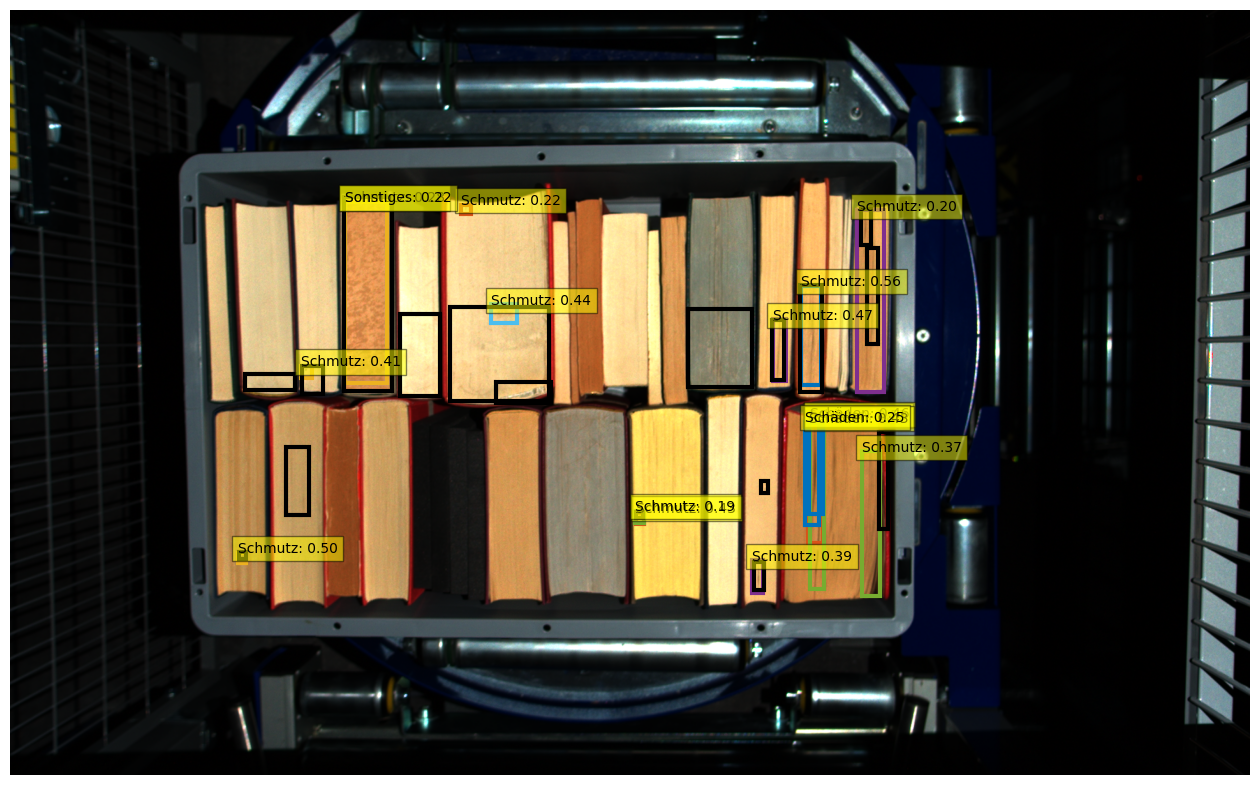

{'scores': tensor([0.6243, 0.4452, 0.4369, 0.3644, 0.3366, 0.2910, 0.2807, 0.2732, 0.2574,
        0.2473, 0.2017, 0.1932, 0.1871, 0.1859], device='cuda:0'), 'labels': tensor([3, 3, 3, 9, 6, 4, 3, 3, 3, 3, 6, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[1275.3016,  646.4241, 1312.6254,  716.1725],
        [1152.7229,  668.8652, 1174.0428,  701.9052],
        [ 344.7751,  675.0685,  362.8290,  698.1706],
        [1046.4254,  359.6653, 1090.6263,  567.8636],
        [1177.2322,  285.0281, 1198.7725,  337.9112],
        [1052.5880,  751.5736, 1072.1007,  850.4109],
        [1052.5880,  751.5736, 1072.1007,  850.4109],
        [ 795.9920,  658.0051,  810.8896,  691.1352],
        [1249.4995,  888.7578, 1260.5249,  914.2709],
        [ 633.5336,  708.1794,  653.0507,  737.0449],
        [1052.5880,  751.5736, 1072.1007,  850.4109],
        [1120.3979,  510.0677, 1175.2554,  585.4778],
        [ 941.1401,  646.4497,  958.5802,  709.4087],
        [ 795.1859,  656.2457,  813.6240,  696.5653]

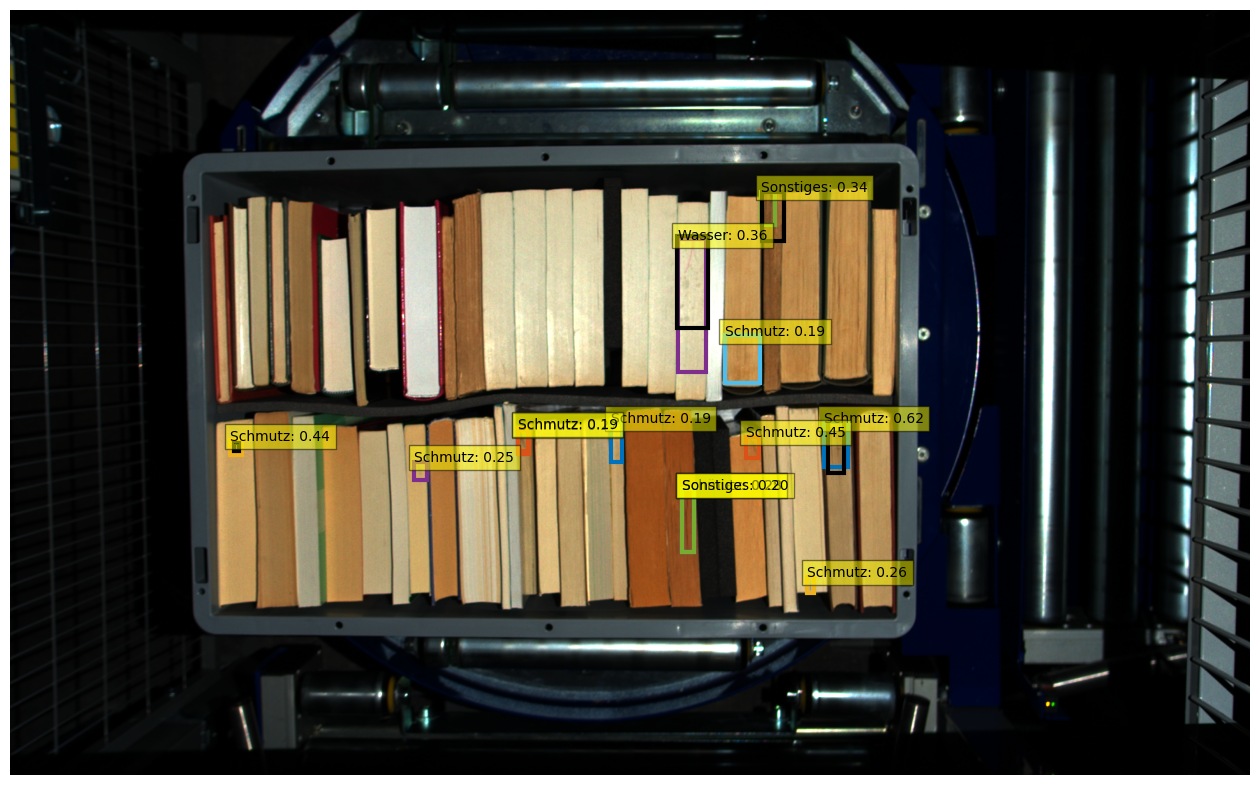

{'scores': tensor([0.6382, 0.5681, 0.5116, 0.3972, 0.3608, 0.3585, 0.2982, 0.2267, 0.2103,
        0.1973, 0.1933, 0.1835], device='cuda:0'), 'labels': tensor([3, 3, 3, 6, 3, 3, 3, 4, 3, 4, 3, 4], device='cuda:0'), 'boxes': tensor([[1082.9821,  541.1590, 1127.1455,  588.6620],
        [1245.3873,  615.4412, 1266.3403,  709.1998],
        [1176.3319,  617.7809, 1203.2963,  690.7472],
        [ 924.8403,  614.7295,  953.9659,  650.0006],
        [ 556.0142,  843.3896,  583.1063,  865.1326],
        [ 327.8146,  759.8218,  359.4864,  883.3646],
        [ 680.9548,  787.2701,  700.5676,  809.1594],
        [ 556.0142,  843.3896,  583.1063,  865.1326],
        [1042.6200,  288.4707, 1056.1506,  327.8436],
        [ 849.4830,  820.1605,  863.0031,  868.5457],
        [ 324.2570,  515.5212,  338.2794,  528.3987],
        [1042.3141,  288.0228, 1056.0160,  328.0606]], device='cuda:0')}
{'Schmutz': 8, 'Sonstiges': 1, 'Schäden': 3}
{'Schmutz': 6, 'Sonstiges': 4, 'Wasser': 1}


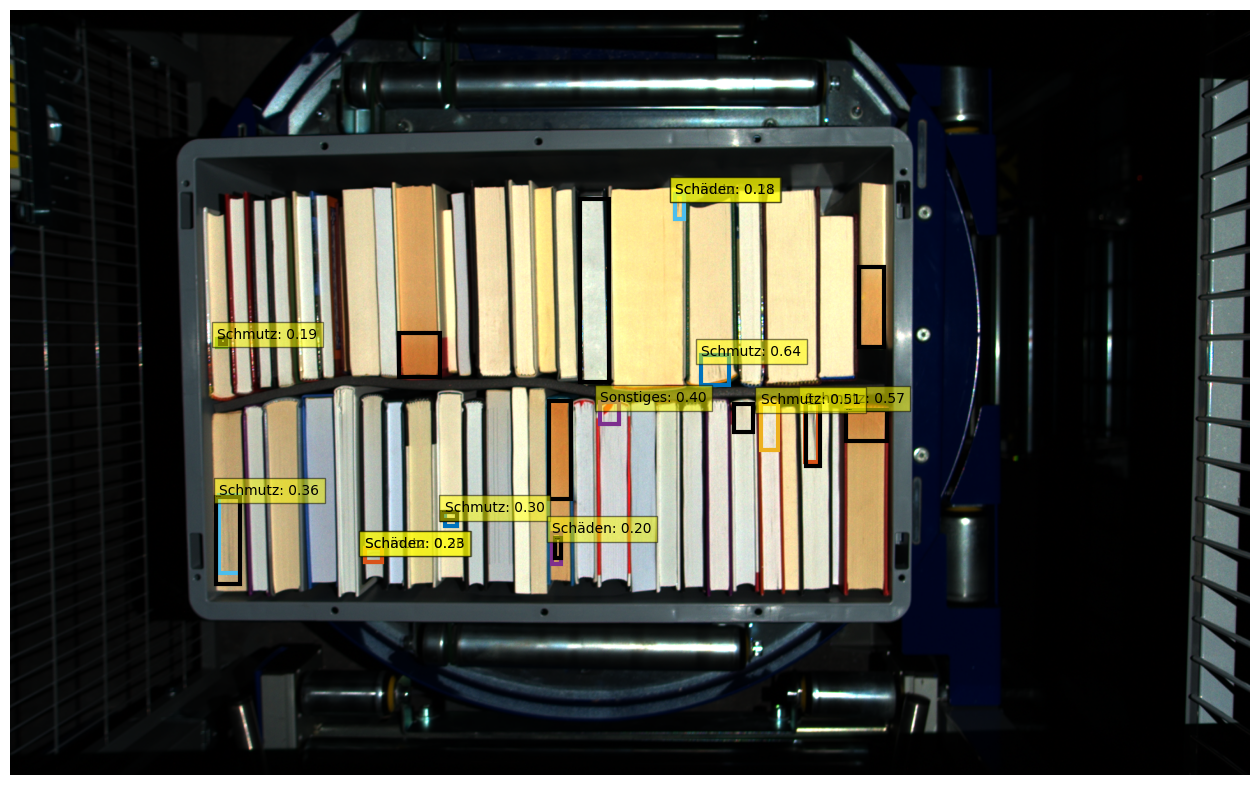

{'scores': tensor([0.5394, 0.3902, 0.3710, 0.3665, 0.3603, 0.3490, 0.3341, 0.3243, 0.2667,
        0.2519, 0.2509, 0.2493, 0.2371, 0.2211, 0.2107, 0.1904],
       device='cuda:0'), 'labels': tensor([3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 6, 9, 3], device='cuda:0'), 'boxes': tensor([[ 397.5877,  468.9825,  417.2501,  488.4695],
        [1092.2421,  645.5156, 1112.0686,  818.9451],
        [ 393.2527,  279.4326,  428.6789,  494.0646],
        [ 398.5233,  378.3912,  428.0782,  417.0143],
        [1328.7539,  611.1172, 1351.1591,  701.5686],
        [ 452.1785,  273.8413,  504.3057,  523.4734],
        [ 397.9763,  508.2512,  421.0214,  530.7043],
        [1328.7539,  611.1172, 1351.1591,  701.5686],
        [ 460.0529,  504.8134,  496.8972,  529.7128],
        [1092.5273,  643.6148, 1113.9038,  825.5192],
        [ 891.3594,  807.2740,  903.7622,  836.7529],
        [1189.9723,  641.4529, 1213.6429,  673.8464],
        [ 332.9804,  284.5609,  368.4809,  494.0338],
        [1092.2421,  64

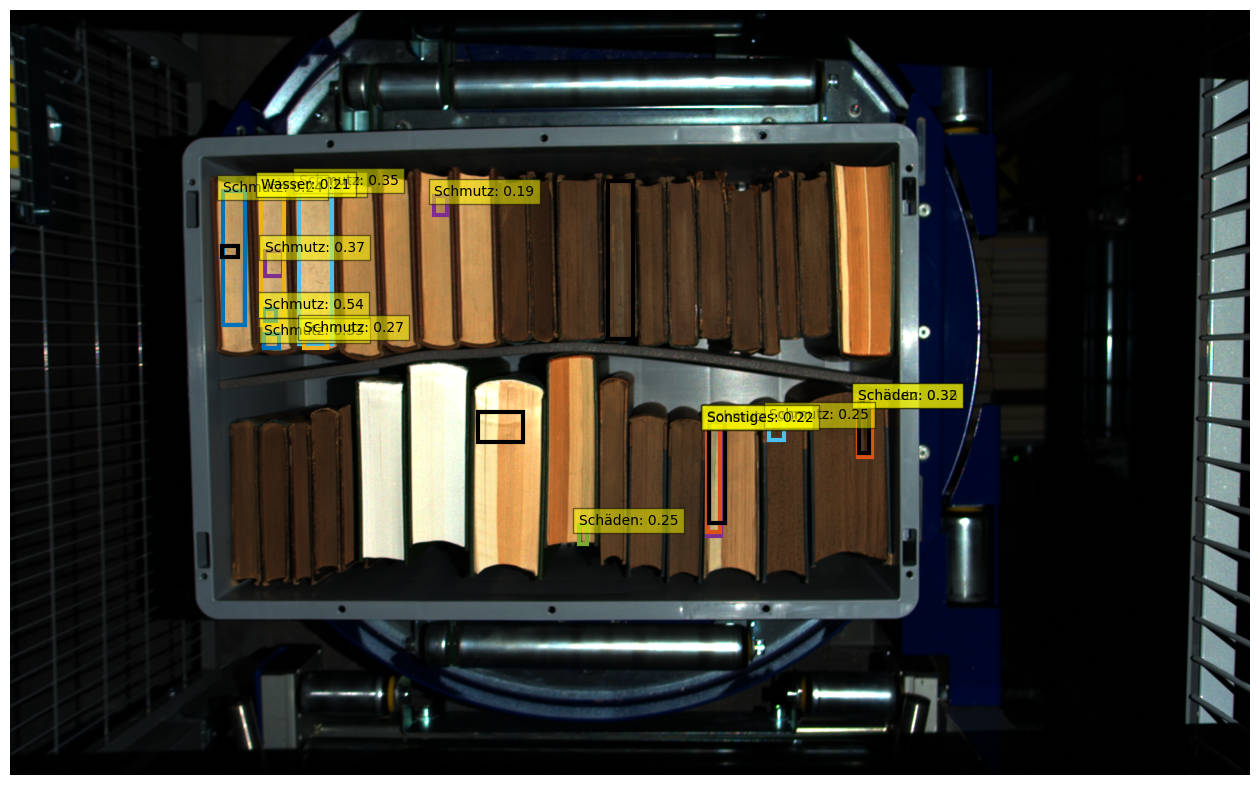

{'scores': tensor([0.5827, 0.4707, 0.3994, 0.3644, 0.3459, 0.2893, 0.2808, 0.2363, 0.2058,
        0.2029], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 6, 3, 3, 3, 6, 3], device='cuda:0'), 'boxes': tensor([[1280.5459,  595.6105, 1312.4352,  664.7155],
        [1034.1058,  606.3895, 1058.9088,  645.7817],
        [ 468.1073,  535.4421,  482.6733,  554.2534],
        [1278.7528,  593.5938, 1321.5422,  670.2764],
        [ 355.9520,  599.5468,  370.7615,  620.5575],
        [1043.2495,  858.7891, 1059.0721,  900.5007],
        [1321.2161,  595.4199, 1337.4799,  634.1327],
        [ 466.4363,  533.8821,  484.6706,  555.9976],
        [ 352.9398,  598.7369,  369.5512,  622.7797],
        [ 990.5756,  820.6284, 1010.9548,  854.2069]], device='cuda:0')}
{'Schmutz': 8, 'Sonstiges': 2}
{'Sonstiges': 2, 'Schmutz': 6}


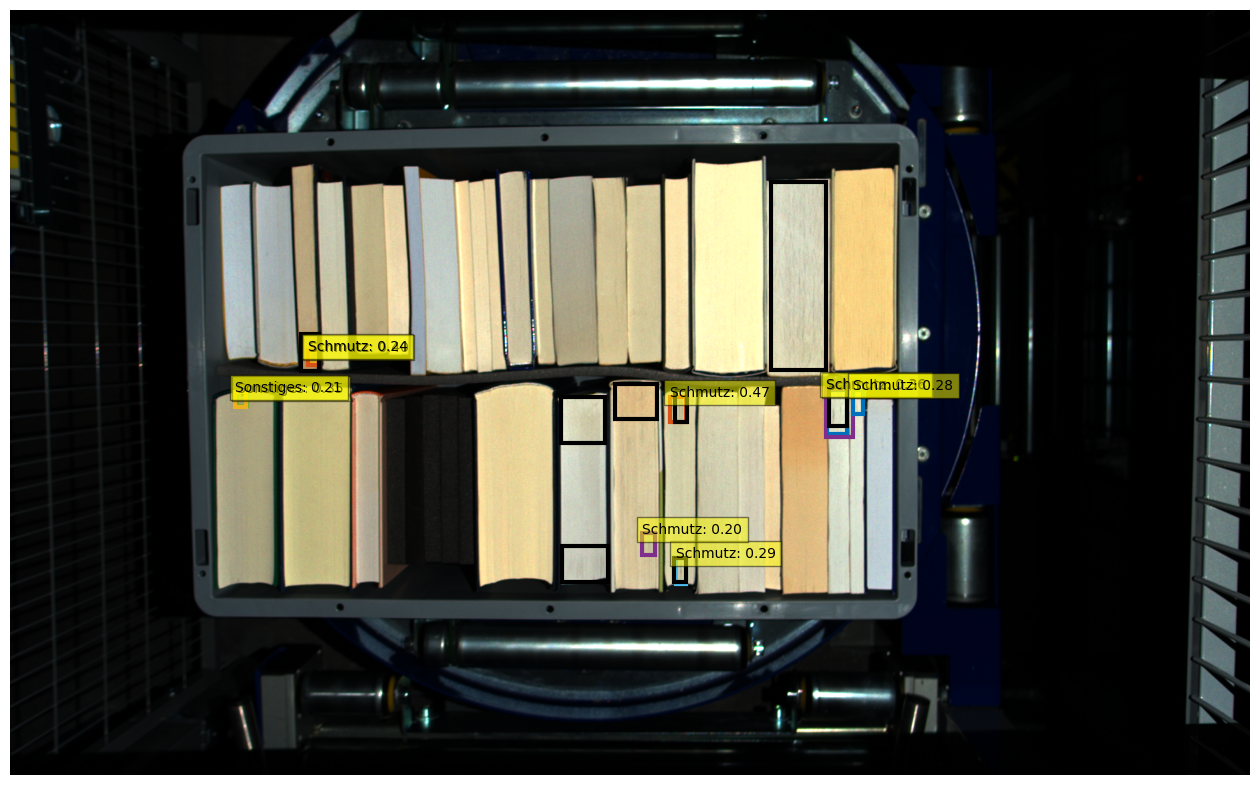

{'scores': tensor([0.4871, 0.4146, 0.3964, 0.3862, 0.3856, 0.3772, 0.3704, 0.3591, 0.3531,
        0.3336, 0.3275, 0.3265, 0.3098, 0.2946, 0.2643, 0.2636, 0.2617, 0.2550,
        0.2539, 0.2439, 0.2413, 0.2325, 0.2266, 0.2150], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4],
       device='cuda:0'), 'boxes': tensor([[ 401.9336,  791.8100,  417.7236,  807.1242],
        [ 735.9182,  450.6982,  822.1675,  486.0836],
        [ 747.8448,  414.6310,  833.0100,  443.0826],
        [ 619.0877,  327.7485,  654.0104,  353.3267],
        [1313.6941,  623.9208, 1358.2213,  637.6870],
        [ 872.8969,  477.8072,  928.0852,  494.0469],
        [ 975.5065,  543.3507,  995.7814,  555.7790],
        [ 745.4125,  727.0079,  793.1400,  737.3533],
        [ 754.5917,  454.2927,  822.7074,  487.2297],
        [ 956.1388,  273.7094, 1059.9017,  290.7491],
        [ 360.3254,  433.7748,  552.8083,  478.6488],
        [ 774.6125,  732.3212,  841

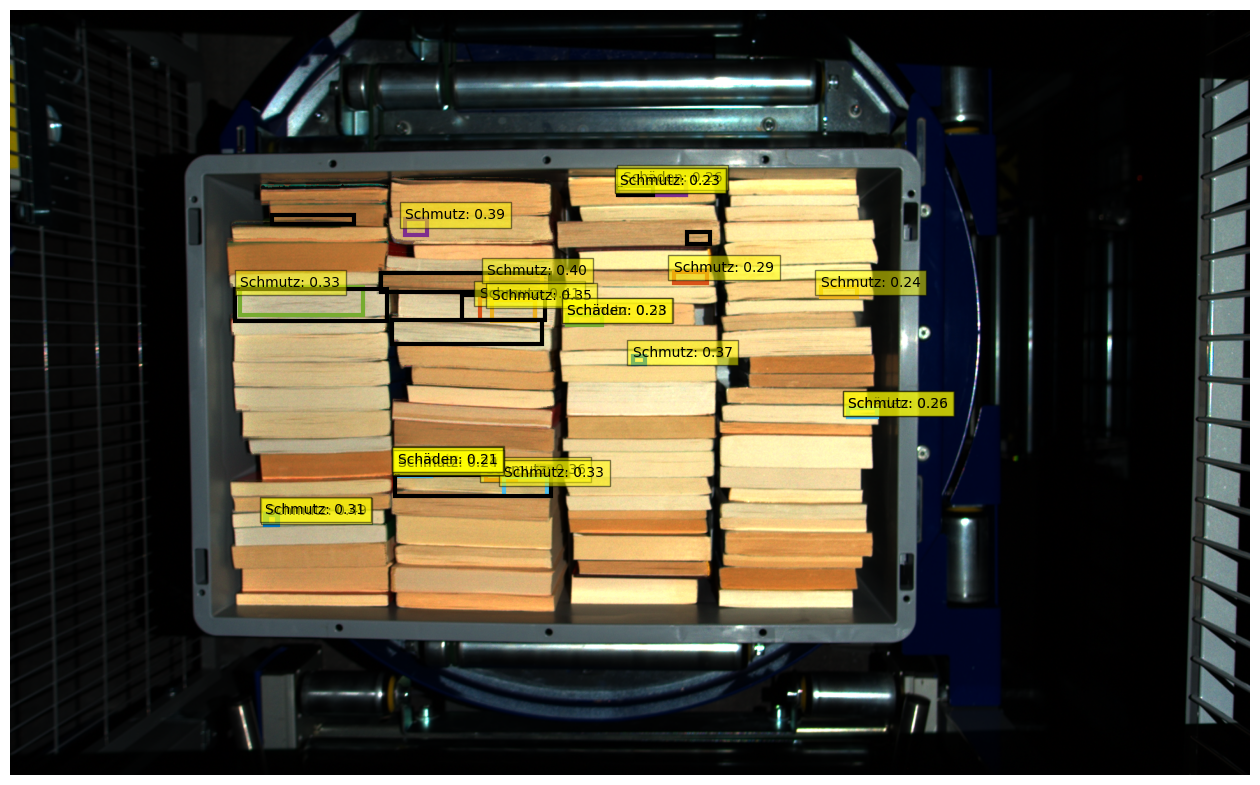

In [8]:
# Visualize
# TODO for a specific label use one specific color
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=10,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='black', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_max', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.18)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)

In [45]:
x = {'labels': [{'size': torch.tensor([ 800, 1296], device='cuda:0'), 'image_id': torch.tensor([20443], device='cuda:0'), 'class_labels': torch.tensor([3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3], device='cuda:0'), 'boxes': torch.tensor([[0.2096, 0.4859, 0.0399, 0.0215],
        [0.2438, 0.4840, 0.0172, 0.0364],
        [0.2883, 0.3713, 0.0383, 0.2544],
        [0.3304, 0.4504, 0.0321, 0.1073],
        [0.4138, 0.5002, 0.0445, 0.0279],
        [0.3943, 0.4495, 0.0798, 0.1226],
        [0.6195, 0.4441, 0.0096, 0.0776],
        [0.6457, 0.4289, 0.0181, 0.1400],
        [0.6899, 0.2837, 0.0076, 0.0479],
        [0.6951, 0.3741, 0.0092, 0.1248],
        [0.1875, 0.7129, 0.0057, 0.0093],
        [0.5074, 0.6600, 0.0050, 0.0074],
        [0.6039, 0.7395, 0.0078, 0.0371],
        [0.6086, 0.6238, 0.0057, 0.0160],
        [0.7040, 0.6147, 0.0073, 0.1277],
        [0.5725, 0.4416, 0.0511, 0.1027],
        [0.2317, 0.6155, 0.0192, 0.0892]], device='cuda:0'), 'area': torch.tensor([ 847.6823,  419.4721, 9632.8975, 2344.4541,  324.3682, 6766.8066,
         560.3406, 2288.1863,  183.3673,  661.5347,   36.9824,   29.0828,
         236.8991,   67.3009,  397.1856, 4885.4731, 1037.4435],
       device='cuda:0'), 'iscrowd': torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), 'orig_size': torch.tensor([1200, 1944], device='cuda:0')}]}

In [93]:
x["labels"][0]["class_labels"][2]

tensor(4, device='cuda:0')

In [40]:
for x in range(0, 0):
    print("djalkfj")

In [86]:
y = torch.tensor([0])

In [90]:
y[0]

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [72]:
y.size()

torch.Size([1])

In [73]:
z = y.size()

In [50]:
z = torch.tensor([0.2438, 0.4840, 0.0172, 0.0364])
z[0]

tensor(0.2438)

In [58]:
if z == torch.tensor([]):
    print("hi")

In [75]:
z[0]

1

In [104]:
n = [{'scores': torch.tensor([0.6273, 0.6238, 0.6178, 0.6165, 0.6139, 0.6118, 0.6084, 0.6084, 0.6073,
        0.6072, 0.6066, 0.6059, 0.6058, 0.6054, 0.6054, 0.6052, 0.6050, 0.6043,
        0.6025, 0.6020, 0.6017, 0.6010, 0.6002, 0.5995, 0.5993, 0.5990, 0.5989,
        0.5988, 0.5964, 0.5962, 0.5960, 0.5960, 0.5941, 0.5933, 0.5930, 0.5920,
        0.5916, 0.5912, 0.5880, 0.5872, 0.5858, 0.5846, 0.5838, 0.5837, 0.5831,
        0.5831, 0.5828, 0.5819, 0.5809, 0.5807, 0.5802, 0.5801, 0.5799, 0.5775,
        0.5769, 0.5766, 0.5758, 0.5749, 0.5746, 0.5742, 0.5740, 0.5734, 0.5717,
        0.5704, 0.5696, 0.5695, 0.5689, 0.5686, 0.5684, 0.5684, 0.5683, 0.5669,
        0.5665, 0.5662, 0.5658, 0.5651, 0.5646, 0.5643, 0.5640, 0.5640, 0.5635,
        0.5632, 0.5631, 0.5629, 0.5628, 0.5628, 0.5623, 0.5614, 0.5613, 0.5612,
        0.5612, 0.5609, 0.5606, 0.5605, 0.5604, 0.5600, 0.5600, 0.5594, 0.5592,
        0.5590], device='cuda:0'), 'labels': torch.tensor([2, 2, 4, 9, 4, 2, 2, 2, 4, 9, 9, 9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        4, 2, 2, 9, 9, 4, 4, 9, 4, 9, 9, 4, 9, 4, 4, 2, 9, 4, 9, 4, 9, 9, 2, 4,
        2, 2, 2, 2, 9, 2, 9, 9, 9, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 9, 9, 2, 9,
        9, 4, 0, 9, 4, 4, 9, 4, 4, 4, 4, 4, 0, 4, 9, 4, 4, 4, 4, 9, 4, 4, 4, 4,
        4, 4, 0, 4], device='cuda:0'), 'boxes': torch.tensor([[ 676.2388,  277.1254,  850.7404,  625.0176],
        [ 491.5782,  608.8383,  664.5103,  935.7572],
        [ 245.1959,   30.2981, 1908.2277, 1173.9956],
        [ 862.0541, 1072.7997,  989.9567, 1112.1863],
        [ 317.2450,   22.0593, 1450.0930,  330.5922],
        [ 388.6223,    5.3880,  637.9678,  199.8394],
        [ 606.6195,  338.1898,  677.1177,  614.6801],
        [ 832.0270,  614.6859,  973.1371,  932.7524],
        [ 288.2072,   10.3697, 1837.5369,  447.6088],
        [ 764.4576,  160.3179,  911.5189,  198.4788],
        [ 701.6495,  159.8817,  943.4083,  194.7039],
        [ 793.9598,  158.5940,  946.8500,  197.9476],
        [ 271.4940,   72.6817, 1910.3503,  611.1729],
        [ 970.0051,  106.4567, 1097.7736,  142.6047],
        [ 843.1724,  106.4497,  961.6071,  141.5147],
        [ 984.1047,  154.2677, 1203.7831,  187.1603],
        [ 889.5905,  106.8443, 1006.0449,  140.3231],
        [ 748.9282,  158.6208,  997.1929,  191.0836],
        [ 898.5062,  106.3222, 1101.9955,  144.9065],
        [ 761.7839,  156.8068, 1050.6472,  187.2452],
        [ 856.7856,  161.5986, 1078.5540,  198.9951],
        [ 629.3372,   72.2920,  706.5010,  130.5994],
        [ 831.1205,  105.8166,  992.0811,  136.3994],
        [ 735.0187,  104.6248,  998.1118,  135.4265],
        [ 362.8256,    7.4454, 1430.8937,  251.0522],
        [1062.8165,  287.1315, 1233.4741,  603.4262],
        [ 407.9402,  606.9929,  644.2662,  940.0078],
        [ 783.8613,  153.9332, 1066.2512,  181.5553],
        [ 823.7746,  105.5136, 1064.1918,  135.8379],
        [ 204.1723,  598.1271, 1878.0404, 1177.5947],
        [ 288.9090,  200.1757, 1437.0602,  973.5871],
        [ 855.7324,  163.4534, 1164.6575,  198.6117],
        [ 270.7104,   91.4500, 1456.1766,  700.7239],
        [ 920.4334,  106.2333, 1166.8995,  135.2824],
        [ 879.5668,  105.8654, 1106.7937,  135.1730],
        [ 233.2137,  387.9187, 1509.7170, 1175.8739],
        [ 710.6248,   79.1035,  947.1807,  110.2706],
        [ 287.1901,  245.8605, 1421.9178,  622.1282],
        [ 744.9787,   46.2645, 1857.5127, 1153.2631],
        [ 444.7609,  288.1731,  637.1275,  608.7245],
        [ 841.8706,  217.1818,  986.1880,  246.9627],
        [ 264.0420,  216.1142, 1428.3958,  332.6553],
        [ 796.8151,  217.5832,  891.8583,  247.7887],
        [ 398.1796,   59.0355, 1419.2971,  211.7155],
        [1066.6624,  211.2775, 1304.0228,  244.4843],
        [1087.7819,  201.9277, 1307.7440,  235.8141],
        [ 612.2525,  621.8962,  757.0402,  935.7299],
        [ -19.4005,  976.6158, 1795.9170, 1188.5854],
        [ 400.7997,    4.5456,  568.1109,  196.2637],
        [ 321.0241,  605.9488,  547.1797,  936.0553],
        [ 428.1929,   38.3956,  554.8650,  199.8660],
        [ 746.6036,  615.0887,  971.1607,  935.0892],
        [1102.4276,  207.2869, 1372.0725,  242.2401],
        [1072.1843,  268.3727, 1380.2273,  940.6075],
        [ 946.0789,  212.6116, 1191.3138,  244.1134],
        [ 855.3904,  214.8240, 1148.2393,  244.2358],
        [ 526.0251,   84.6113,  956.9733,  159.2933],
        [1602.9233, 1065.2534, 1829.8510, 1178.2430],
        [-242.1230, -158.3021,  591.4835,  859.7520],
        [1035.1334,   24.6038, 1912.5560, 1176.9390],
        [ 335.6111,  284.0186,  677.6199,  943.9149],
        [ 135.1845,  549.4729, 1398.5144, 1165.3425],
        [-271.7565, -259.6675,  620.7223,  518.3907],
        [ 266.8770,  979.6051, 1503.4895, 1183.5458],
        [ 413.4843,   28.3230, 1088.3103,  201.7365],
        [ 120.5829,  922.5416, 1641.0110, 1187.8499],
        [1040.3624,  269.0762, 1410.5273,  947.1584],
        [ 336.1257,  986.8702, 1197.7725, 1164.8531],
        [ 771.3053,  614.1293,  871.9078,  646.2388],
        [ 808.9615,  917.7413, 1042.6924,  969.2343],
        [ 361.3281,  288.9001,  601.4477,  612.9789],
        [1798.4371,  -47.2978, 2046.5907,   95.5865],
        [ 346.3434,  216.3328,  481.6689,  238.2121],
        [ 605.1952,  703.0776, 1852.5463, 1195.7296],
        [ 346.3434,  216.3328,  481.6689,  238.2121],
        [ 559.0224,   68.1338, 1055.6260,  148.4330],
        [1664.7755, 1051.6240, 1876.0095, 1191.6969],
        [ 214.1127,  209.4996, 1016.6656, 1164.9806],
        [ 511.7601,   85.6599, 1151.7854,  191.8203],
        [1834.2233, 1116.4379, 1945.0957, 1196.0771],
        [-205.5402, -105.0520,  916.1711,  466.4155],
        [ 254.4914, 1122.7365,  511.3465, 1189.0867],
        [ 257.3645,  217.7309, 1414.2401,  250.7157],
        [1281.4097,   21.8314, 1939.2560, 1181.8925],
        [1331.4860, -106.3575, 2310.1462,  391.7843],
        [1646.0857,   41.0714, 1847.3046,  135.3579],
        [ 356.8601,  865.6786,  858.8425, 1001.6323],
        [1797.8419,  112.0865, 1922.6658,  372.2739],
        [ 511.7601,   85.6599, 1151.7854,  191.8203],
        [  21.5554,  859.8798, 1493.3877, 1180.0155],
        [ 263.6172,  212.8943, 1442.7341,  240.9092],
        [ 516.8245,   82.9084,  857.6564,  198.6778],
        [1579.3196,  865.5213, 1845.1697, 1170.8385],
        [ 998.0509,  -69.6900, 2263.0579,  420.4548],
        [1000.9614,  593.9443, 1878.0334, 1170.8518],
        [ 875.6599, 1072.2188, 1000.1871, 1112.0150],
        [ 303.8547,  262.9725,  969.4770,  947.5837],
        [  52.9637,  755.6959, 1336.9678, 1213.2312],
        [ 998.0509,  -69.6900, 2263.0579,  420.4548],
        [ -46.3515,  570.4091,  991.9885, 1162.0546]], device='cuda:0')}]

In [106]:
n["labels"]

TypeError: list indices must be integers or slices, not str